In [1]:
import pandas as pd
import numpy as np
from math import isnan

In [2]:
file = open('data/20news/train.label')
train_labels = pd.read_csv(file, delimiter=' ', squeeze=True)

class_counts = train_labels.value_counts()
#print(class_counts, len(train_labels))
#print(train_labels)

In [3]:
# Calculate the priors ( probability of each class based on the frequencies )
priors = {}
for cl, cnt in class_counts.iteritems():
    priors[cl] = cnt / len(train_labels)
print('Priors: ', priors)

Priors:  {16: 0.053159389421370253, 11: 0.053070642527511536, 9: 0.052893148739794109, 12: 0.052715654952076675, 14: 0.052715654952076675, 10: 0.052715654952076675, 15: 0.052626908058217965, 6: 0.052538161164359248, 8: 0.052538161164359248, 13: 0.052449414270500531, 4: 0.052094426695065671, 7: 0.0516506922257721, 2: 0.051561945331913384, 5: 0.051029463968761096, 3: 0.050763223287184946, 18: 0.050053248136315232, 17: 0.048367057152999646, 1: 0.042509762158324457, 19: 0.041178558750443732, 20: 0.033368832090876821}


In [4]:
train_df = pd.read_csv('data/20news/train.data', delimiter=' ', names=['docIdx', 'wordIdx', 'count'])
train_df = train_df.drop(train_df[train_df.docIdx == 11269].index) # delete rows of document 11269 because labels for this doc don't exist :/
class_col = []
row_per_doc = train_df.groupby('docIdx').count()['count']
#print(row_per_doc)

for i, v in row_per_doc.iteritems():
    #print(i)
    tmp = [train_labels[i-1]] * v
    class_col += tmp

train_df['classIdx'] = class_col


print(train_df.head())

   docIdx  wordIdx  count  classIdx
0       1        1      4         1
1       1        2      2         1
2       1        3     10         1
3       1        4      4         1
4       1        5      2         1


$$ P(x_i \mid \omega_j) = \frac{\sum tf(x_i, d \in \omega_j) + \alpha}{\sum N_{d \in \omega j} + \alpha \cdot V} $$

In [5]:
# Length of all Vocabulary
file = open('data/20news/vocabulary.txt')
vocab_series = pd.read_csv(file, squeeze=True)
len_vocab = len(vocab_series)
print(len_vocab)

61187


In [6]:

# Multinomial Likelyhood
alpha = 0.001 # Laplace Smoothing
count_words_per_class = train_df.groupby(['wordIdx', 'classIdx'])['count'].sum()
count_words_in_class = train_df.groupby('classIdx')['count'].sum()
likelyhood = (count_words_per_class + alpha) / (count_words_in_class + len_vocab*alpha)
likelyhood = likelyhood.unstack()

# replace NaN values with Zeros
#likelyhood = likelyhood.reset_index()

#'''
# replace Zeroes with the true result of the equation ( [0+alpha] / [count_words_in_class + len*alpha] )
for c in priors:
    v = alpha / (count_words_in_class[c] + len_vocab*alpha)
    likelyhood.loc[:, c] = likelyhood.loc[:,c].fillna(v)
assert(likelyhood.isnull().any().any() == False)
#'''

#likelyhood.loc[2,2]
likelyhood.head()

classIdx,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
wordIdx,,,,,,,,,,,,,,,,,,,,
1,0.000089,5.321824e-04,1.210815e-04,8.073485e-05,6.945748e-05,3.075133e-04,1.633421e-08,7.888405e-05,1.363328e-04,9.320629e-06,7.054851e-06,2.592633e-04,2.908899e-05,9.677741e-05,3.114275e-04,4.963932e-09,1.080436e-04,3.921896e-05,5.369266e-09,8.397421e-09
2,0.000430,5.233128e-04,7.594530e-04,3.128185e-04,3.819640e-04,1.452485e-03,4.573743e-04,4.557326e-04,6.718879e-04,3.072828e-04,4.722099e-04,4.487212e-04,3.198819e-04,2.516109e-04,5.320174e-04,6.105686e-04,1.876505e-04,6.039156e-04,2.094068e-04,3.778923e-04
3,0.001878,8.869558e-09,1.100641e-08,1.009059e-08,1.157432e-08,6.542696e-09,1.633421e-08,8.763920e-09,9.737365e-09,9.311318e-09,7.047803e-09,4.985736e-09,9.693098e-09,6.451397e-09,6.487938e-09,7.942788e-05,5.686206e-09,3.921504e-09,5.369266e-09,7.558518e-05
4,0.000061,1.507914e-04,1.871199e-04,1.009059e-08,1.158589e-05,5.168795e-04,3.268476e-05,8.763920e-09,3.895920e-05,1.863195e-05,7.047803e-09,5.484808e-05,1.939589e-05,8.387461e-05,1.427411e-04,3.475249e-05,3.412292e-05,3.529746e-05,1.234985e-04,1.680324e-05
5,0.000560,1.241827e-04,2.311455e-04,1.009160e-04,1.158589e-05,9.814699e-05,3.268476e-05,1.139397e-04,3.895920e-05,9.320629e-06,7.054851e-06,2.941634e-04,4.847518e-05,1.225830e-04,8.434968e-05,6.950002e-05,6.255395e-05,7.846930e-06,9.128290e-05,1.931491e-04


In [7]:
# Remove some meaningless stop words

stop_words = [
"a", "about", "above", "across", "after", "afterwards", 
"again", "all", "almost", "alone", "along", "already", "also",    
"although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another", "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "as", "at", "be", "became", "because", "become","becomes", "becoming", "been", "before", "behind", "being", "beside", "besides", "between", "beyond", "both", "but", "by","can", "cannot", "cant", "could", "couldnt", "de", "describe", "do", "done", "each", "eg", "either", "else", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "find","for","found", "four", "from", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "i", "ie", "if", "in", "indeed", "is", "it", "its", "itself", "keep", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mine", "more", "moreover", "most", "mostly", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next","no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own", "part","perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "she", "should","since", "sincere","so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "take","than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they",
"this", "those", "though", "through", "throughout",
"thru", "thus", "to", "together", "too", "toward", "towards",
"under", "until", "up", "upon", "us",
"very", "was", "we", "well", "were", "what", "whatever", "when",
"whence", "whenever", "where", "whereafter", "whereas", "whereby",
"wherein", "whereupon", "wherever", "whether", "which", "while", 
"who", "whoever", "whom", "whose", "why", "will", "with",
"within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
]

tmp = vocab_series.isin(stop_words)
vocab = {}
forbidden = {}
for i in range(len(vocab_series)):
    if tmp[i] == False:
        vocab[i] = vocab_series[i]
    else:
        forbidden[i] = vocab_series[i]

for k in forbidden:
    for c in priors:
        likelyhood.loc[k, c] = alpha/(count_words_in_class[c] + len_vocab*alpha)

In [8]:
#np.log(0.000089)*5

In [9]:
# Predict

def predict(in_features_df): # in_features_df is a dataframe ['docIdx', 'wordIdx', 'count'] with the same docIdx
    ret = {} # returns a dict {class1: prob, class2: prob, class3: prob, ...}
    for c in priors:
        pr = 0
        for i, r in in_features_df.iterrows():
            try: # sometimes there are wordId's that never occured in the training, I set their probs to zero right away to avoid error
                p = likelyhood.loc[r['wordIdx'], c]
                cnt = r['count']
            except:
                p = alpha / (count_words_in_class[c] +len_vocab*alpha)
                cnt = 0
            pr += (np.log(cnt+1)*np.log(p))
        pr += priors[c]
        ret[c] = pr
        
    return ret

In [10]:
# Read test data

test_df = pd.read_csv('data/20news/test.data', delimiter=' ', names=['docIdx', 'wordIdx', 'count'])
test_doc_ids = test_df.docIdx.unique()
test_doc_ids = test_doc_ids[:len(test_doc_ids)-2]
print(test_doc_ids)
test_df = test_df.set_index('docIdx')

file = open('data/20news/test.label')
test_labels = pd.read_csv(file, delimiter=' ', squeeze=True)
#print(test_labels)
test_class_counts = test_labels.value_counts()

[   1    2    3 ..., 7501 7502 7503]


In [11]:
# Score
verbose = True

results = {} # dict doc => predicted_class, probability, error?
errors = dict.fromkeys(list(priors.keys()), 0) # class => nbr_errors

for doc in test_doc_ids:
    probs = predict(test_df.loc[doc])
    prediction = max(probs.items(), key=(lambda k: k[1]))

    correct_class   = test_labels[doc-1]
    predicted_class = prediction[0]
    predicted_prob  = prediction[1]

    error = predicted_class != correct_class
    if error:
        errors[correct_class] += 1

    results[doc] = (predicted_class, predicted_prob, error)

    if verbose == True and doc%100 == 0:
        print(f"Scoring {doc}/{len(test_doc_ids)} ( errors : {errors[correct_class]}/{test_class_counts[correct_class]})")

Scoring 100/7503 ( errors : 19/317)
Scoring 200/7503 ( errors : 33/317)
Scoring 300/7503 ( errors : 61/317)
Scoring 400/7503 ( errors : 12/389)
Scoring 500/7503 ( errors : 33/389)
Scoring 600/7503 ( errors : 62/389)
Scoring 700/7503 ( errors : 93/389)
Scoring 800/7503 ( errors : 31/391)
Scoring 900/7503 ( errors : 68/391)
Scoring 1000/7503 ( errors : 116/391)
Scoring 1100/7503 ( errors : 2/392)
Scoring 1200/7503 ( errors : 38/392)
Scoring 1300/7503 ( errors : 62/392)
Scoring 1400/7503 ( errors : 92/392)
Scoring 1500/7503 ( errors : 2/383)
Scoring 1600/7503 ( errors : 29/383)
Scoring 1700/7503 ( errors : 51/383)
Scoring 1800/7503 ( errors : 73/383)
Scoring 1900/7503 ( errors : 5/390)
Scoring 2000/7503 ( errors : 35/390)
Scoring 2100/7503 ( errors : 69/390)
Scoring 2200/7503 ( errors : 101/390)
Scoring 2300/7503 ( errors : 10/382)
Scoring 2400/7503 ( errors : 31/382)
Scoring 2500/7503 ( errors : 56/382)
Scoring 2600/7503 ( errors : 76/382)
Scoring 2700/7503 ( errors : 3/395)
Scoring 2800

In [12]:
# Show Results


print("Score per Class:")
total_nbr_errors = 0
class_scores= {}
for c in errors:
    total_nbr_errors += errors[c]
    score_of_class = 1-(errors[c]/test_class_counts[c])
    class_scores[c] = score_of_class*100
    print(f"{c} => {score_of_class}%")

total_score = 1 - (total_nbr_errors/len(test_labels))
print("Total Score: {}%".format(total_score*100))


Score per Class:
16 => 0.8542713567839196%
11 => 0.9548872180451128%
9 => 0.9319899244332494%
12 => 0.8987341772151899%
14 => 0.8346055979643766%
10 => 0.9093198992443325%
15 => 0.8647959183673469%
6 => 0.6923076923076923%
8 => 0.850632911392405%
13 => 0.6972010178117048%
4 => 0.7015306122448979%
7 => 0.7879581151832461%
2 => 0.7609254498714653%
5 => 0.7571801566579635%
3 => 0.5856777493606138%
18 => 0.8404255319148937%
17 => 0.8351648351648352%
1 => 0.7854889589905363%
19 => 0.5935483870967742%
20 => 0.6533864541832669%
Total Score: 79.45095948827291%


<IPython.core.display.Javascript object>


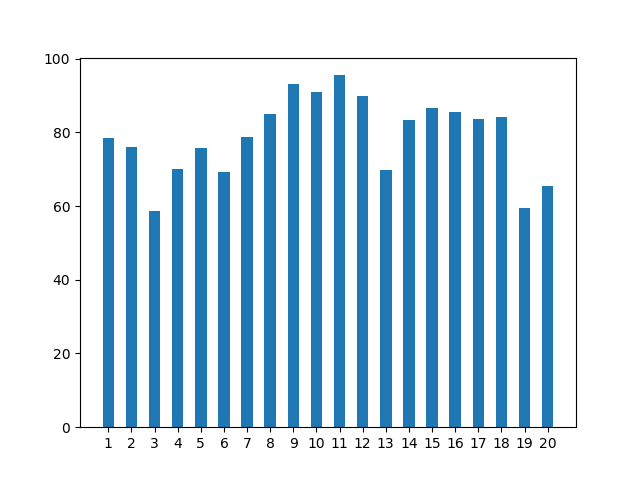

<Container object of 20 artists>

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
x = list(class_scores.keys())
y = list(class_scores.values())

plt.bar(x, y, 1/2, align='center')
plt.xticks(x, x)
plt.title('My title')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()